In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\mediamill.csv")

df.head()

,id,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,...,Class92,Class93,Class94,Class95,Class96,Class97,Class98,Class99,Class100,Class101
0,1,0.380877,0.494079,0.540009,0.422926,0.158318,0.326975,0.390861,0.527121,0.254052,...,0,0,0,0,0,0,0,0,0,0
1,2,0.508613,0.505837,0.437155,0.490723,0.262201,0.459610,0.393838,0.524006,0.370391,...,0,0,0,0,0,0,0,0,0,0
2,3,0.449571,0.460490,0.453469,0.410779,0.231759,0.402147,0.349590,0.536456,0.318117,...,0,0,0,0,0,0,0,0,0,0
3,4,0.416800,0.548996,0.520850,0.465410,0.181603,0.357255,0.389347,0.530189,0.290942,...,0,0,0,0,0,0,0,0,0,0
4,5,0.501986,0.480820,0.435543,0.432002,0.250599,0.408353,0.357816,0.499186,0.353172,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df = df.drop(columns=['id'])

In [4]:
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class92,Class93,Class94,Class95,Class96,Class97,Class98,Class99,Class100,Class101
0,0.380877,0.494079,0.540009,0.422926,0.158318,0.326975,0.390861,0.527121,0.254052,0.223731,...,0,0,0,0,0,0,0,0,0,0
1,0.508613,0.505837,0.437155,0.490723,0.262201,0.459610,0.393838,0.524006,0.370391,0.329424,...,0,0,0,0,0,0,0,0,0,0
2,0.449571,0.460490,0.453469,0.410779,0.231759,0.402147,0.349590,0.536456,0.318117,0.301615,...,0,0,0,0,0,0,0,0,0,0
3,0.416800,0.548996,0.520850,0.465410,0.181603,0.357255,0.389347,0.530189,0.290942,0.244521,...,0,0,0,0,0,0,0,0,0,0
4,0.501986,0.480820,0.435543,0.432002,0.250599,0.408353,0.357816,0.499186,0.353172,0.327622,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

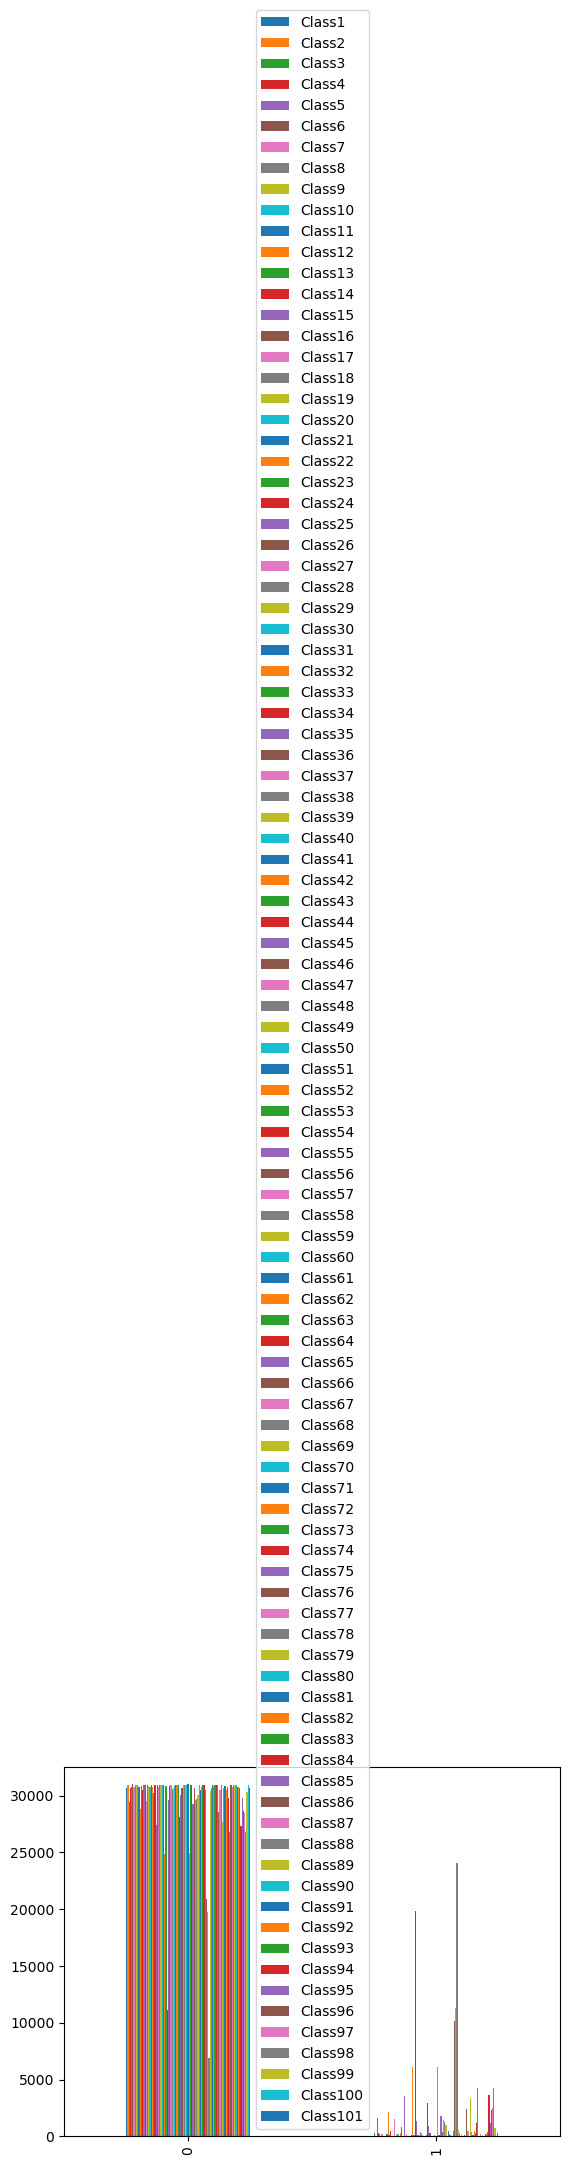

In [5]:
df1 = df[df.columns[120:]]
df2 = df1.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

In [2]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

In [7]:
import numpy as np

def get_tail_label(data: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = data.sum(axis=0)
    irlbl = irlbl[(irlbl > np.quantile(irlbl,ql[0])) & ((irlbl < np.quantile(irlbl,ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = np.median(irlbl)
    tail_label = pd.Series(irlbl)[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    y_df = pd.DataFrame(y)
    X_df = pd.DataFrame(X)
    tail_labels = get_tail_label(y_df, ql=ql)
    index = y_df[y_df[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X_df[X_df.index.isin(index)].reset_index(drop = True)
    y_sub = y_df[y_df.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [8]:
X = np.asarray(df[df.columns[0:120]])
y = np.asarray(df[df.columns[120:]])

X_sub, y_sub = get_minority_samples(X, y)
X_res, y_res = MLSMOTE(X_sub, y_sub, 7200, 5)  # Applying MLSMOTE to augment the dataframe

<AxesSubplot:>

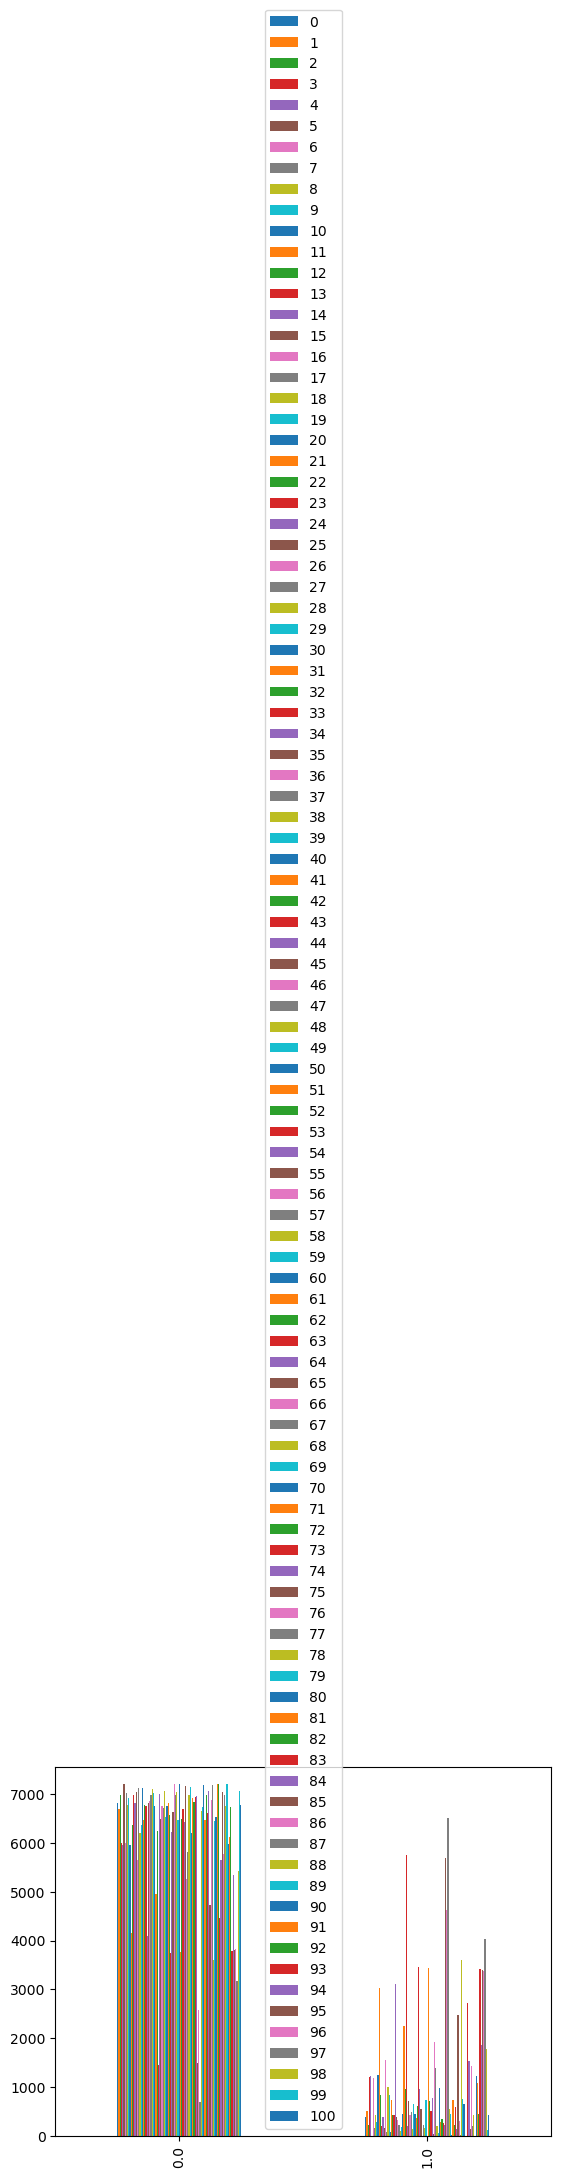

In [9]:
df3 = y_res.apply(pd.value_counts).fillna(0)
df3.plot(kind="bar")

In [3]:
df_resampled = pd.read_csv('C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\resampled_mediamill.csv')
df_resampled.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,91.1,92.1,93.1,94.1,95.1,96.1,97.1,98.1,99.1,100.1
0,0,0.551666,0.502459,0.439292,0.394874,0.270457,0.423478,0.341472,0.491645,0.387044,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0.270137,0.141186,0.108798,0.148215,0.361425,0.239933,0.127404,0.136578,0.343115,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,0.449310,0.326185,0.278394,0.266938,0.387986,0.359726,0.234834,0.311593,0.431600,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0.466317,0.540328,0.581458,0.371442,0.192490,0.341152,0.350422,0.511940,0.320385,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.473580,0.388341,0.334611,0.357033,0.348924,0.448433,0.293521,0.406477,0.404277,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [7]:
X_res = np.asarray(df_resampled[df_resampled.columns[0:121]])
y_res = np.asarray(df_resampled[df_resampled.columns[121:]])

In [15]:
y_df = pd.DataFrame(y_res)
y_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [11]:

irlbl = y_df.sum(axis=0)
print(irlbl)

0       388.0
1       513.0
2       229.0
3      1200.0
4      1235.0
        ...  
96     3381.0
97     4031.0
98     1784.0
99      133.0
100     423.0
Length: 101, dtype: float64


In [16]:
y_df = y_df.drop(columns=[5,46,50,82,89])

In [19]:
y_res = np.asarray(y_df)

In [10]:
df_res = pd.concat([X_res, y_res], axis=1)

In [11]:
df_res.to_csv(r'C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\resampled_mediamill.csv')

In [20]:
from sklearn.model_selection import train_test_split

X = np.asarray(X_res)
y = np.asarray(y_res)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [21]:
from skmultilearn.adapt import MLkNN

mlknn_classifier = MLkNN(k=3)
mlknn_classifier.fit(X_train , y_train)
predictions = mlknn_classifier.predict(X_test)

C:\Users\KIIT\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: Inexact indices into sparse matrices are not allowed

In [22]:
unique_classes = np.unique(y_train)
print(unique_classes)

[0. 1.]


In [23]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

classifier = BinaryRelevance(
    classifier = SVC(),
    require_dense = [False, True]
)
# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [24]:
import sklearn.metrics as metrics
metrics.hamming_loss(y_test, predictions)

0.13119695216049382

In [25]:
import sklearn.metrics as metrics
metrics.accuracy_score(y_test, predictions)

0.0

In [26]:
metrics.average_precision_score(y_test, predictions.todense())

0.15667698541879438

In [27]:
metrics.recall_score(y_test, predictions,average='macro')

0.059605949095369516

In [28]:
metrics.f1_score(y_test, predictions, average='macro')

0.050342960687233235

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

In [30]:
metrics.hamming_loss(y_test, y_pred)

0.055372299382716046

In [31]:
metrics.accuracy_score(y_test, y_pred)

0.3194444444444444

In [33]:
metrics.average_precision_score(y_test, y_pred)

0.5032382353834629

In [34]:
metrics.recall_score(y_test, y_pred,average='macro')

0.47617108123519847

In [35]:
metrics.f1_score(y_test, y_pred, average='macro')

0.6073022853699093